<a href="https://colab.research.google.com/github/xc308/Diffusion_Sampling/blob/main/Score_based_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip -q install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.3 MB/s eta 0:00:00


In [6]:

import jax
import jax.numpy as jnp
import numpy as np
import optax    # for optimization
import haiku as hk  # for network
from torch.utils.data import Dataset, dataloader

print('JAX version: {}'.format(jax.__version__))

JAX version: 0.7.2


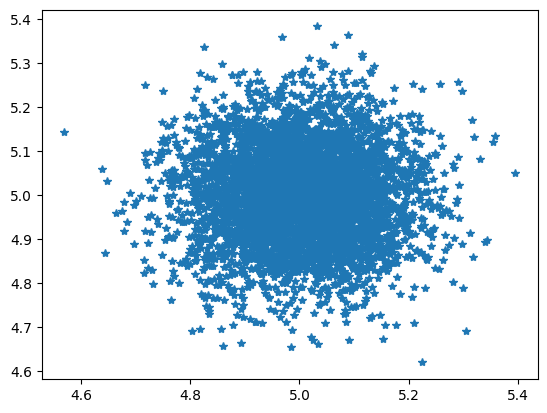

In [7]:
N_samples = 5000 # 5000 rows
dimension = 2    # each sample has 2 dim (x1, x2), 2 columns

std = 0.105
# shift = np.random.randint(0, size=(N_samples, dimension)) - 0
mu = 5
X_train = std * np.random.randn(N_samples, dimension) + mu


import matplotlib.pyplot as plt
plt.plot(X_train[:, 0], X_train[:,1], '*')
plt.show()


In [8]:
print(X_train.shape)

(5000, 2)


In [7]:
print(X_train)

[[4.93078912 5.1044217 ]
 [4.92724101 4.96451674]
 [5.00496498 4.95810443]
 ...
 [4.984664   5.0098688 ]
 [4.9403319  5.03353796]
 [4.94124255 5.05449144]]


In [9]:
t = 4
print("t: ", t)
print("t_expand: ", np.expand_dims(t, axis=0))

t:  4
t_expand:  [4]


## First, defining a target dataset and the diffusion dataset (Forward noising process)


In [10]:


T = 5

class TargetDataset(Dataset):
    def __init__(self, X):
        self.X = X
        self.N_samples = X.shape[0]
        self.dimension = X.shape[1]

    def __len__(self):
        return self.N_samples

    def __getitem__(self, idx):
        return self.X[idx, :]



class DiffusionDataset(Dataset):      # forward noising process
    def __init__(self, target_ds, T):
        self.target_ds = target_ds
        self.T = T

    def __len__(self):
        return self.target_ds.__len__()

    def sampler(self, t, x0):
        coeff1 = np.exp(-t)
        coeff2 = np.sqrt(1 - np.exp(-2*t))
        z = np.random.randn(*x0.shape)
        xt = coeff1 * x0 + coeff2 * z
        return np.expand_dims(t, axis=0), xt, z / coeff2  # np.expand_dims(t, axis=0) turns a scalar t into a 1D array

    def __getitem__(self, idx):
        t = np.random.uniform(0, self.T)
        x0 = self.target_ds.__getitem__(idx)
        return self.sampler(t, x0)



target_ds = TargetDataset(X_train)
diff_ds = DiffusionDataset(target_ds, T)


## Now define the dataloader (with torch) using these datasets.

- The only difficulty is that we have to modify the collate function from torch.

In [11]:
bs = 128

def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(np.array(samples)) for samples in transposed]



diff_dl = dataloader.DataLoader(dataset = diff_ds, batch_size= bs, shuffle=True, collate_fn=numpy_collate)

## Define the NN model

In [13]:
def ScoreNetwork(t, x):
    mlpt = hk.Sequential([hk.Linear(16), jax.nn.relu, hk.Linear(16), jax.nn.relu,]) # two layer NN, each layer with 16 weights and 16 bias
    mlpx = hk.Sequential([hk.Linear(16), jax.nn.relu, hk.Linear(16), jax.nn.relu,])
    mlpconcat = hk.Sequential([hk.Linear(32), jax.nn.relu, hk.Linear(32), jax.nn.relu,
                               hk.Linear(x.shape[-1]),]) # the final layer is the same size as x_t
    outt = mlpt(t)
    outx = mlpx(x)
    return mlpconcat(jnp.concatenate((outt, outx), axis=-1))

model = hk.transform(ScoreNetwork) # transform a the NN to two functions, model.init and model.apply
model = hk.without_apply_rng(model) # NN forward pass, but no random dropout

## Define Loss Function


In [1]:
def compute_loss(params, model, t, xt, pred):
    out = model.apply(params, t, xt).squeeze()
    return jnp.mean(optax.l2_loss(out, -pred.squeeze()))

## Define the optimizer and train the model

In [14]:
nepoch = 1000
nlog = 100
lr = 1e-3


optimizer = optax.adam(lr)
outinit = next(iter(diff_dl)) # diff_dl output t_batch, xt_batch, pred_batch, iterate over each batch

key = jax.random.PRNGKey(42)
params = model.init(key, outinit[0], outinit[1]) # use outinit[0], outinit[1] as example to  initialize the shape of weights and bias,
                                                 # output of params are is the collection of all the weights and biases that will be updated during training.

internal_states = optimizer.init(params) # set up internal variables of adam, e.g., momentum buffers, for each
                                  # of NN model's params, crucial for accelerating
                                  # convergence and adapting learning rates for each params


for n in range(nepoch):
    for t, xt, pred in diff_dl: # t, xt, and pred are t_batch, xt_batch, pred_batch
        loss, grad = jax.value_and_grad(compute_loss)(params, model, t, xt, pred)
        update, internal_states = optimizer.update(grad, internal_states) # output1: changes to the each model's params
                                                                          # output2: updated internal state of the optimizer
        params = optax.apply_updates(params, update) # element-wise new pars = current pars + updated_changes to be made
    if n % nlog == 0:
        print('Loss value: {:2f}'.format(loss))



/usr/local/lib/python3.12/dist-packages/haiku/_src/initializers.py:122: UserWarning: Explicitly requested dtype float64 requested in convert_element_type is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  m = jax.lax.convert_element_type(self.mean, dtype)
/usr/local/lib/python3.12/dist-packages/haiku/_src/initializers.py:123: UserWarning: Explicitly requested dtype float64 requested in convert_element_type is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  s = jax.lax.convert_element_type(self.stddev, real_dtype)
/usr/local/lib/python3.12/dist-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dty

Loss value: 0.560805
Loss value: 0.007057
Loss value: 0.016667
Loss value: 0.004358
Loss value: 0.033327
Loss value: 0.005466
Loss value: 0.045907
Loss value: 0.009099
Loss value: 0.008947
Loss value: 0.260776


Here's how you would correctly rename the iterator variables:

## Define Sampler: Euler-Maruyama + Langevin

In [15]:
class Sampler():
    def __init__(self, diff_ds, gamma, predictor_step):
        self.diff_ds = diff_ds
        self.gamma = gamma
        self.predictor_step = predictor_step

    def EMsampler(self, model, params, y0, log_freq=0.1):
        gamma = self.gamma
        T = self.diff_ds.T
        N_EM = int(T / gamma)
        #N_log = int(log_freq * N_EM)
        N_log = max(1, int(log_freq * N_EM)) # avoid int(log_freq * N_EM) = 0 cause trouble for k % N_log == 0
        y = y0
        t = np.zeros((y0.shape[0], 1)) + T
        out_list = [[t, y]]
        for k in range(N_EM):
            t = t - gamma
            z = np.random.randn(*y.shape) # y.shape is a tuple (1000, 2), *y.shape unpack the tuple and put the numbers as args of np.random.randn(1000, 2)
            y = y + gamma * y + 2 * gamma * model.apply(params, t, y) + np.sqrt(2 * gamma) * z

            # fine-tune with Langevin sampler
            for _ in range(self.predictor_step):
                z = np.random.randn(*y.shape)
                y = y + gamma * model.apply(params, t, y) + np.sqrt(2 * gamma) * z
            if k % N_log == 0:
                out_list.append([t, y])

        out_list.append([t, y])     # record the final state generated sample at t = 0
        out_list_transposed = list(zip(*out_list)) # see below
        return N_EM, np.stack(out_list_transposed[0]), np.stack(out_list_transposed[1])

In [ ]:
# out_list is a list of lists
# *out_list unpack the outer list to be a collection of lists for zip function
# zip aggregates elements from each of them. It pairs up the first elements from all the input lists, then the second elements from all the input lists, and so on.
# first output from zip will be tuple (t1, t2, ..., tN), and  second output from zip will be (y1, y2, ..., yN)
# list()

In [16]:
N_samples_test = 1000
gamma = 1e-3
predictor_step = 3

y0 = np.random.randn(N_samples_test, dimension)
sampler = Sampler(diff_ds, gamma, predictor_step)
N_EM, outt, outy = sampler.EMsampler(model, params, y0) # params are the one updated by NN training

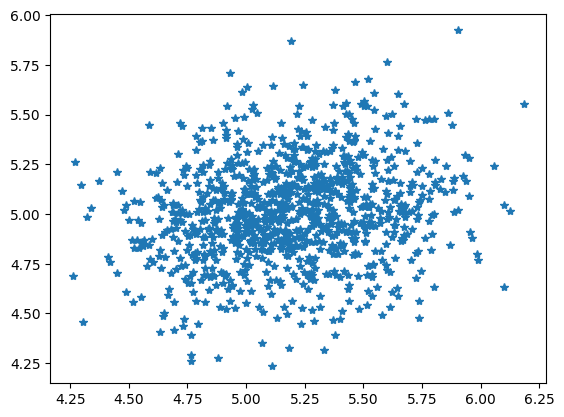

In [17]:
plt.plot(outy[-1,:,0], outy[-1,:,1], '*')
plt.show()

In [7]:
# Finally, apply np.stack to each part

# Stacking the 't' arrays
stacked_t = np.stack(out_list_transposed[0])
print(f"\nResult of np.stack(out_list_transposed[0]) (stacked t values):\n{stacked_t}")
print(f"Shape of stacked_t: {stacked_t.shape}")

# Stacking the 'y' arrays
stacked_y = np.stack(out_list_transposed[1])
print(f"\nResult of np.stack(out_list_transposed[1]) (stacked y values):\n{stacked_y}")
print(f"Shape of stacked_y: {stacked_y.shape}")


Result of np.stack(out_list_transposed[0]) (stacked t values):
[[5. ]
 [4.5]
 [4. ]]
Shape of stacked_t: (3, 1)

Result of np.stack(out_list_transposed[1]) (stacked y values):
[[[0.54817194 0.02051777]
  [0.60223621 0.16300307]
  [0.0342683  0.36341514]
  [0.51677634 0.95706723]
  [0.2258587  0.99539589]]

 [[0.29124486 0.85621689]
  [0.68938435 0.54931955]
  [0.34716728 1.07316429]
  [0.45173322 0.87585833]
  [0.75803614 0.6165591 ]]

 [[0.63596375 0.91382912]
  [0.97662194 0.27350379]
  [0.75183354 1.02034114]
  [0.4266213  0.54701822]
  [1.03290901 0.33413227]]]
Shape of stacked_y: (3, 5, 2)
